In [1]:
# import libraries
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import sklearn.metrics as skm
import matplotlib.pyplot as plt
import seaborn as sns
import copy, time, matplotlib, sys

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset, Subset
from torchsummary import summary

import torchvision
import torchvision.transforms as T

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
# plt.rcParams.update({'font.size':11})

In [ ]:
# use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

# Two perspectives of the world

In [ ]:
'''
* The main idea behind signal-detection theory.
* The "four categories of responses" in signal-detection theory.
* Why signal-detection theory is useful for measuring performance DL.

- Hit, False alarm, Miss, Correct rejection
- Confusion matrix: True positive, False positive, False negative, True negative

* The problem with accuracy
- Accuracy is useful and informative.
- But it hides possible biases.
- And it does not reveal sensitivity.
- Ergo, accuracy should be supplemented with other measures of performance.

'''

# Accuracy, precision, recall, F1

In [ ]:
'''
* Why accuracy is not always the best measure of performance.
* Other performance measures in machine learning.
* The relationship between recall and sensitivity.

* Accuracy formula: (True positives + true negatives) / (Total number of samples)
* Accuracy interpretation: Overall model performance, ignoring categories and sample sizes.

* Precision formula: (True positives) / (Total number of "yes" predictions)
* Precision interpretation: Includes a cost for "yes" biases. Useful when false positive are bad, like cancer detection.

* Recall formula: (True positives) / (Total number of "present")
* Recall interpretation: Includes a cost for "no" biases. Useful when false negative are bad, like covid19.
- Recall = sensitivity

* F1 score: (True positives) / (TP + (FP+FN)/2)
* F1 interpretation: Balance between precision and recall. F1 score is high only with few mistakes.

'''

## Run the experiments

In [2]:
# run experiment

# number of 'trials' in the experiment
N = 50 # actual trials is 2N

# number of experiment repetitions
numExps = 10000

# initialize
accuracy = np.zeros(numExps)
precision = np.zeros(numExps)
recall = np.zeros(numExps)
F1score = np.zeros(numExps)

In [3]:
# run the experiment!
for expi in range(numExps):

    # generate data
    TP = np.random.randint(1, N)        # true positives, aka hits
    FN = N - TP                                    # false negatives, aka misses
    TN = np.random.randint(1, N)        # true negatives, aka correct rejections
    FP = N - TN                                    # false positives, aka false alarms

    # the four performance measures

    # accuracy
    accuracy[expi] = (TP + TN) / (2*N)

    # precision
    precision[expi] = TP / (TP + FP)

    # recall
    recall[expi] = TP / (TP + FN)

    # F1score
    F1score[expi] = TP / ( TP + (FN+FP)/2)

In [5]:
# let's see how they relate to each other!

fig, ax = plt.subplots(1,2,figsize=(12,4))

ax[0].scatter(accuracy, F1score, s=4, c=precision)
ax[0].plot([0,1], [.5,.5], 'k--', linewidth=.5)
ax[0].plot([.5,.5], [0,1], 'k--', linewidth=.5)
ax[0].set_xlabel('Accuracy')
ax[0].set_ylabel('F1-score')
ax[0].set_title('F1-Accuracy by precision')

ax[1].scatter(accuracy,F1score,s=4,c=recall)
ax[1].plot([0,1],[.5,.5],'k--',linewidth=.5)
ax[1].plot([.5,.5],[0,1],'k--',linewidth=.5)
ax[1].set_xlabel('Accuracy')
ax[1].set_ylabel('F1-score')
ax[1].set_title('F1-Accuracy by recall')

plt.show()

# APRF example 1: wine quality

## Import and process the data

In [6]:
# import the data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url, sep=';')

# drop a few outliers
data = data[data['total sulfur dioxide']<200]

# z-score all columns except for quality
cols2zscore = data.keys()
cols2zscore = cols2zscore.drop('quality')
data[cols2zscore] = data[cols2zscore].apply(stats.zscore)

# create a new column for binarized (boolean) quality
data['boolQuality'] = 0
data['boolQuality'][data['quality']>5] = 1

<ipython-input-6-0d607c2faaae>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['boolQuality'][data['quality']>5] = 1


In [11]:
# convert from pandas dataframe to tensor
data_tensor = torch.tensor(data[cols2zscore].values).float()
labels = torch.tensor(data['boolQuality'].values).float()
labels = labels[:,None]

# split the data
train_data, test_data, train_labels, test_labels = train_test_split(data_tensor, labels, test_size=.1)

# convert into PyTorch Datasets
trainset = TensorDataset(train_data, train_labels)
testset = TensorDataset(test_data, test_labels)

# create dataloaders
train_loader = DataLoader(trainset, batch_size=32, shuffle=True, drop_last=True)
test_loader = DataLoader(testset, batch_size=testset.tensors[0].shape[0])

## Now for the DL part

In [8]:
# create a class for the model

class ANNwine(nn.Module):
    def __init__(self):
        super().__init__()

        # input layer
        self.input = nn.Linear(11,16)

        # hidden layers
        self.fc1 = nn.Linear(16,32)
        self.fc2 = nn.Linear(32,32)

        # output layer
        self.output = nn.Linear(32,1)

    # forward pass
    def forward(self, x):
        x = F.relu(self.input(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.output(x)

## A function to train the model

In [9]:
# global parameter
numepochs = 1000

def trainTheModel(winenet):

    # loss function and optimizer
    lossfunc = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.SGD(winenet.parameters(), lr=.01)

    # initialize losses
    losses = torch.zeros(numepochs)
    trainAcc = []
    testAcc = []

    # loop over epochs
    for epochi in range(numepochs):

        # loop over training data batches
        batchAcc = []
        batchLoss = []
        for X, y in train_loader:

            # forward pass and loss
            yHat = winenet(X)
            loss = lossfunc(yHat, y)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # loss and accuracy for this batch
            batchLoss.append(loss.item())
            batchAcc.append( 100 * torch.mean(((yHat>0)==y).float()).item() )

        # average training accuracy and average losses across the batches
        losses[epochi] = np.mean(batchLoss)
        trainAcc.append(np.mean(batchAcc))

        # test accuracy
        X, y = next(iter(test_loader))
        with torch.no_grad():
            yHat = winenet(X)
        testAcc.append( 100 * torch.mean(((yHat>0)==y).float()).item() )

    # function output
    return trainAcc, testAcc, losses, winenet

## Now to create the fitted model

In [12]:
# create and train a model
winenet = ANNwine()
trainAcc, testAcc, losses, winenet = trainTheModel(winenet)

## Compute the performance measures on the train and test data

In [13]:
# predictions for training data
train_predictions = winenet(train_loader.dataset.tensors[0])
train_predictions

tensor([[ 7.8575],
        [ 1.4808],
        [ 0.8082],
        ...,
        [-1.8323],
        [-5.3708],
        [-1.7348]], grad_fn=<AddmmBackward0>)

In [ ]:
# predictions for test data
test_predictions = winenet(test_loader.dataset.tensors[0])
test_predictions

In [15]:
# NEW! using scikitlearn to compute ARPF

# initialize vectors
train_metrics = [0,0,0,0]
test_metrics = [0,0,0,0]

# training
train_metrics[0] = skm.accuracy_score(train_loader.dataset.tensors[1], train_predictions>0)
train_metrics[1] = skm.precision_score(train_loader.dataset.tensors[1], train_predictions>0)
train_metrics[2] = skm.recall_score(train_loader.dataset.tensors[1], train_predictions>0)
train_metrics[3] = skm.f1_score(train_loader.dataset.tensors[1], train_predictions>0)

# test
test_metrics[0] = skm.accuracy_score(test_loader.dataset.tensors[1], test_predictions>0)
test_metrics[1] = skm.precision_score(test_loader.dataset.tensors[1], test_predictions>0)
test_metrics[2] = skm.recall_score(test_loader.dataset.tensors[1], test_predictions>0)
test_metrics[3] = skm.f1_score(test_loader.dataset.tensors[1], test_predictions>0)

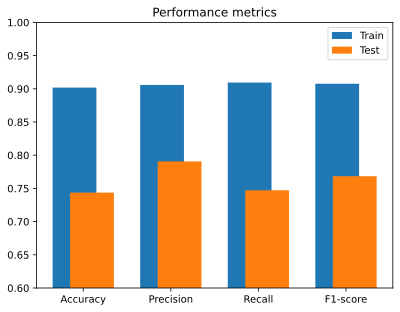

In [17]:
plt.bar(np.arange(4)-.1, train_metrics, .5)
plt.bar(np.arange(4)+.1, test_metrics, .5)
plt.xticks([0,1,2,3], ['Accuracy', 'Precision', 'Recall', 'F1-score'])
plt.ylim([.6,1])
plt.legend(['Train','Test'])
plt.title('Performance metrics')
plt.show()

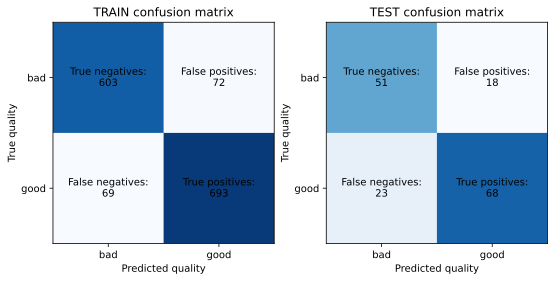

In [18]:
# Confusion matrices
train_conf = skm.confusion_matrix(train_loader.dataset.tensors[1], train_predictions>0)
test_conf = skm.confusion_matrix(test_loader.dataset.tensors[1], test_predictions>0)

fig, ax = plt.subplots(1,2,figsize=(9,4))

# confmat during TRAIN
ax[0].imshow(train_conf, 'Blues', vmax=len(train_predictions)/2)
ax[0].set_xticks([0,1])
ax[0].set_yticks([0,1])
ax[0].set_xticklabels(['bad', 'good'])
ax[0].set_yticklabels(['bad', 'good'])
ax[0].set_xlabel('Predicted quality')
ax[0].set_ylabel('True quality')
ax[0].set_title('TRAIN confusion matrix')

# add text labels
ax[0].text(0,0,f'True negatives:\n{train_conf[0,0]}' ,ha='center',va='center')
ax[0].text(0,1,f'False negatives:\n{train_conf[1,0]}',ha='center',va='center')
ax[0].text(1,1,f'True positives:\n{train_conf[1,1]}' ,ha='center',va='center')
ax[0].text(1,0,f'False positives:\n{train_conf[0,1]}',ha='center',va='center')

# confmat during TEST
ax[1].imshow(test_conf,'Blues',vmax=len(test_predictions)/2)
ax[1].set_xticks([0,1])
ax[1].set_yticks([0,1])
ax[1].set_xticklabels(['bad','good'])
ax[1].set_yticklabels(['bad','good'])
ax[1].set_xlabel('Predicted quality')
ax[1].set_ylabel('True quality')
ax[1].set_title('TEST confusion matrix')

# add text labels
ax[1].text(0,0,f'True negatives:\n{test_conf[0,0]}' ,ha='center',va='center')
ax[1].text(0,1,f'False negatives:\n{test_conf[1,0]}',ha='center',va='center')
ax[1].text(1,1,f'True positives:\n{test_conf[1,1]}' ,ha='center',va='center')
ax[1].text(1,0,f'False positives:\n{test_conf[0,1]}',ha='center',va='center')
plt.show()

In [19]:
train_conf

array([[603,  72],
       [ 69, 693]])

# APRF example2: MNIST

## Import and process the data

In [20]:
# import dataset
data = np.loadtxt(open('sample_data/mnist_train_small.csv', 'rb'), delimiter=',')

# extract labels and remove from data
labels = data[:, 0]
data = data[:, 1:]

# normalize the data to a range of [0 1]
dataNorm = data / np.max(data)

In [21]:
# Step 1 : convert to tensor
data_tensor = torch.tensor(dataNorm).float()
labels_tensor = torch.tensor(labels).long()

# Step 2 : split the data
train_data, test_data, train_labels, test_labels = train_test_split(data_tensor, labels_tensor, test_size=.1)

# Step 3 : convert into PyTorch Datasets
trainset = TensorDataset(train_data, train_labels)
testset = TensorDataset(test_data, test_labels)

# Step 4 : translate into dataloader objects
batchsize=32
train_loader = DataLoader(trainset, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader = DataLoader(testset, batch_size=testset.tensors[0].shape[0])

## Create the DL model

In [26]:
# create a class for the model
def createTheMNISTNet():

    class mnistNet(nn.Module):
        def __init__(self):
            super().__init__()

            # input layer
            self.input = nn.Linear(784, 64)

            # hidden layer
            self.fc1 = nn.Linear(64,32)
            self.fc2 = nn.Linear(32,32)

            # output layer
            self.output = nn.Linear(32,10)

        # forward pas
        def forward(self, x):
            x = F.relu(self.input(x))
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            return self.output(x)

    # create the model instance
    net = mnistNet()

    # loss function
    lossfunc = nn.CrossEntropyLoss()

    # optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=.01)

    return net, lossfunc, optimizer

## Create a function that trains the model

In [27]:
def function2trainTheModel():

    # number of epochs
    numepochs = 10

    # create a new model
    net, lossfunc, optimizer = createTheMNISTNet()

    # initialize losses
    losses = torch.zeros(numepochs)
    trainAcc = []
    testAcc = []

    # loop over epochs
    for epochi in range(numepochs):

        # loop over training data batches
        batchAcc = []
        batchLoss = []
        for X, y in train_loader:

            # forward pass and loss
            yHat = net(X)
            loss = lossfunc(yHat, y)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # batch loss and accuracy
            batchLoss.append(loss.item())
            batchAcc.append( 100 * torch.mean((torch.argmax(yHat, axis=1)==y).float()).item() )

        # average loss & acc across the batches
        trainAcc.append( np.mean(batchAcc) )
        losses[epochi] = np.mean(batchLoss)

        # test accuracy
        X, y = next(iter(test_loader))
        with torch.no_grad():
            yHat = net(X)

        testAcc.append( 100 * torch.mean((torch.argmax(yHat, axis=1)==y).float()).item() )

    # function output
    return trainAcc, testAcc, losses, net

## Run the model and show the results!

In [28]:
# build and train the model
trainAcc, testAcc, losses, net = function2trainTheModel()

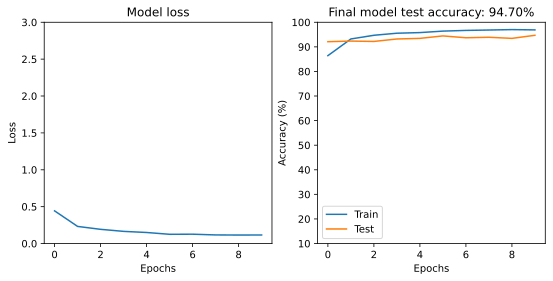

In [29]:
# visualization starts here
fig, ax = plt.subplots(1,2,figsize=(9,4))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,3])
ax[0].set_title('Model loss')

ax[1].plot(trainAcc, label='Train')
ax[1].plot(testAcc, label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10,100])
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

## Compute the performance measures on the train and test data

In [30]:
# predicted digits for training data
yHat = net(train_loader.dataset.tensors[0])
train_predictions = torch.argmax(yHat, axis=1)

# predictions for test data
yHat = net(test_loader.dataset.tensors[0])
test_predictions = torch.argmax(yHat, axis=1)
test_predictions

tensor([3, 5, 7,  ..., 8, 1, 4])

In [39]:
# Brief aside on computing precision et al. in multi-class data:
# There are now 10 classes, so there are 10 precision values.

# option 1: compute precision for each class (each number)
skm.precision_score(train_loader.dataset.tensors[1], train_predictions, average=None)

# option 2: compute average precision, weighted by N
skm.precision_score(train_loader.dataset.tensors[1], train_predictions, average='weighted')

# option 3: compute average precision, unweighted (same as "weighted" if category N's are equal)
skm.precision_score(train_loader.dataset.tensors[1], train_predictions, average='macro')

array([0.97246696, 0.99203187, 0.98107958, 0.95835616, 0.99407232,
       0.98821218, 0.99395604, 0.98579695, 0.94273128, 0.97171381])

In [34]:
# initialize vectors
train_metrics = [0,0,0,0]
test_metrics = [0,0,0,0]

# training
train_metrics[0] = skm.accuracy_score(train_loader.dataset.tensors[1], train_predictions) # accuracy is overall
train_metrics[1] = skm.precision_score(train_loader.dataset.tensors[1], train_predictions, average='weighted')
train_metrics[2] = skm.recall_score(train_loader.dataset.tensors[1], train_predictions, average='weighted')
train_metrics[3] = skm.f1_score(train_loader.dataset.tensors[1], train_predictions, average='weighted')

# test
test_metrics[0] = skm.accuracy_score(test_loader.dataset.tensors[1], test_predictions) # accuracy is overall
test_metrics[1] = skm.precision_score(test_loader.dataset.tensors[1], test_predictions, average='weighted')
test_metrics[2] = skm.recall_score(test_loader.dataset.tensors[1], test_predictions, average='weighted')
test_metrics[3] = skm.f1_score(test_loader.dataset.tensors[1], test_predictions, average='weighted')

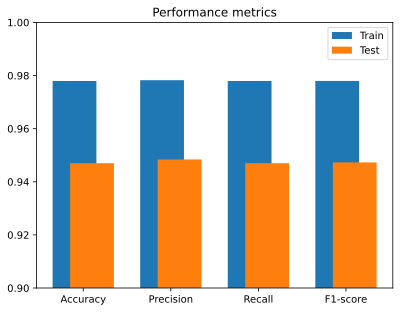

In [35]:
plt.bar(np.arange(4)-.1, train_metrics, .5)
plt.bar(np.arange(4)+.1, test_metrics, .5)
plt.xticks([0,1,2,3], ['Accuracy', 'Precision', 'Recall', 'F1-score'])
plt.ylim([.9,1])
plt.legend(['Train', 'Test'])
plt.title('Performance metrics')
plt.show()

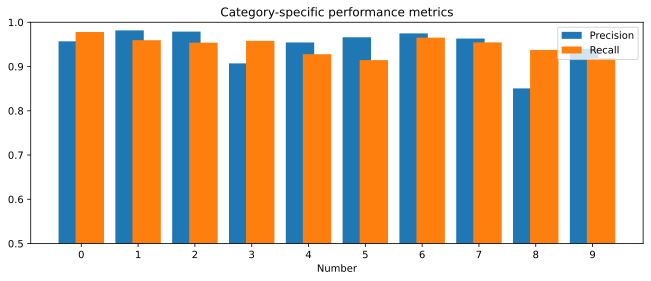

In [37]:
# Bar graphs of class-specific precision and recall for test data

precision = skm.precision_score(test_loader.dataset.tensors[1], test_predictions, average=None)
recall = skm.recall_score(test_loader.dataset.tensors[1], test_predictions, average=None)

fig = plt.figure(figsize=(11,4))
plt.bar(np.arange(10)-.15, precision, .5)
plt.bar(np.arange(10)+.15, recall, .5)
plt.xticks(range(10), range(10))
plt.ylim([.5,1])
plt.xlabel('Number')
plt.legend(['Precision', 'Recall'])
plt.title('Category-specific performance metrics')
plt.show()

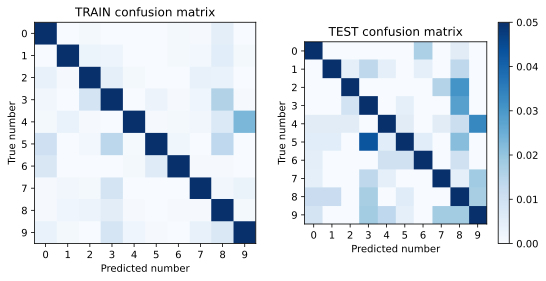

In [38]:
# Confusion matrices
train_conf = skm.confusion_matrix(train_loader.dataset.tensors[1], train_predictions, normalize='true')
test_conf = skm.confusion_matrix(test_loader.dataset.tensors[1], test_predictions, normalize='true')

fig, ax = plt.subplots(1,2,figsize=(9,4))

# confmat during TRAIN
ax[0].imshow(train_conf, 'Blues', vmax=.05)
ax[0].set_xticks(range(10))
ax[0].set_yticks(range(10))
ax[0].set_title('TRAIN confusion matrix')
ax[0].set_ylabel('True number')
ax[0].set_xlabel('Predicted number')

# confmat during TEST
a = ax[1].imshow(test_conf, 'Blues', vmax=.05)
ax[1].set_xticks(range(10))
ax[1].set_yticks(range(10))
ax[1].set_title('TEST confusion matrix')
ax[1].set_ylabel('True number')
ax[1].set_xlabel('Predicted number')

fig.colorbar(a)
plt.show()

# MNIST with unequal groups

## Remove most of the 7's from the data

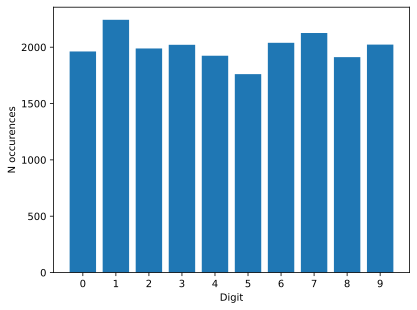

In [40]:
# see whether there is a roughly equal number of elements in each category

# category counts
cat_counts = np.unique(labels, return_counts=True)

# visualize
plt.bar(cat_counts[0], cat_counts[1])
plt.xlabel('Digit')
plt.ylabel('N occurences')
plt.xticks(range(10))
plt.show()

In [59]:
# find all the 7's
where7s = np.where(labels==7)[0]

# how many to remove, to leave 500 in the data
N2remove = where7s.shape[0] - 500

# pick that number of 7's at random
remove7s = np.random.choice(where7s, size=N2remove, replace=False)

In [60]:
# and remove them from the data!
print('Sizes before removing:')
print(dataNorm.shape)
print(labels.shape)

dataNorm = np.delete(dataNorm, remove7s, axis=0)
labels = np.delete(labels, remove7s)

print('\n\nSizes after removing:')
print(dataNorm.shape)
print(labels.shape)

Sizes before removing:
(18374, 784)
(18374,)


Sizes after removing:
(18374, 784)
(18374,)


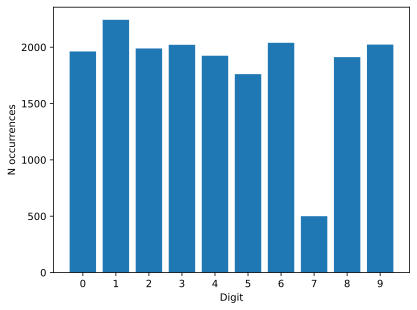

In [50]:
# visual confirmation of our manipulation
cat_counts = np.unique(labels, return_counts=True)
plt.bar(cat_counts[0], cat_counts[1])
plt.xlabel('Digit')
plt.ylabel('N occurrences')
plt.xticks(range(10))
plt.show()

## Moving right along as if nothing happened...

In [61]:
# Step 1 : convert to tensor
data_tensor = torch.tensor(dataNorm).float()
labels_tensor = torch.tensor(labels).long()

# Step 2 : split the data
train_data, test_data, train_labels, test_labels = train_test_split(data_tensor, labels_tensor, test_size=.1)

# Step 3 : convert into PyTorch Datasets
trainset = TensorDataset(train_data, train_labels)
testset = TensorDataset(test_data, test_labels)

# Step 4 : translate into dataloader objects
batchsize=32
train_loader = DataLoader(trainset, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader = DataLoader(testset, batch_size=testset.tensors[0].shape[0])

## Run the model and show the results!

In [62]:
trainAcc, testAcc, losses, net = function2trainTheModel()

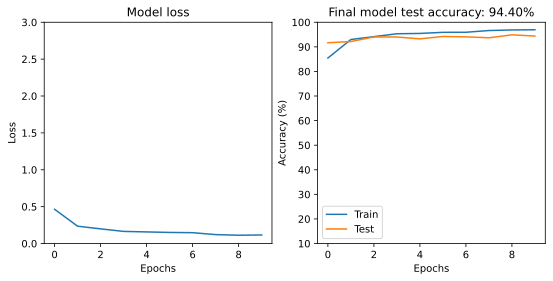

In [63]:
fig, ax = plt.subplots(1,2,figsize=(9,4))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,3])
ax[0].set_title('Model loss')

ax[1].plot(trainAcc, label='Train')
ax[1].plot(testAcc, label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10,100])
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

## Compute the performance measures on the train and test data

In [64]:
# predicted digits for training data
yHat = net(train_loader.dataset.tensors[0])
train_predictions = torch.argmax(yHat, axis=1)

# predictions for test data
yHat = net(test_loader.dataset.tensors[0])
test_predictions = torch.argmax(yHat, axis=1)
test_predictions

tensor([8, 9, 9,  ..., 2, 4, 9])

In [65]:
# initialize vectors
train_metrics = [0,0,0,0]
test_metrics = [0,0,0,0]

# training
train_metrics[0] = skm.accuracy_score(train_loader.dataset.tensors[1], train_predictions) # accuracy is overall
train_metrics[1] = skm.precision_score(train_loader.dataset.tensors[1], train_predictions, average='weighted')
train_metrics[2] = skm.recall_score(train_loader.dataset.tensors[1], train_predictions, average='weighted')
train_metrics[3] = skm.f1_score(train_loader.dataset.tensors[1], train_predictions, average='weighted')

# test
test_metrics[0] = skm.accuracy_score(test_loader.dataset.tensors[1], test_predictions) # accuracy is overall
test_metrics[1] = skm.precision_score(test_loader.dataset.tensors[1], test_predictions, average='weighted')
test_metrics[2] = skm.recall_score(test_loader.dataset.tensors[1], test_predictions, average='weighted')
test_metrics[3] = skm.f1_score(test_loader.dataset.tensors[1], test_predictions, average='weighted')

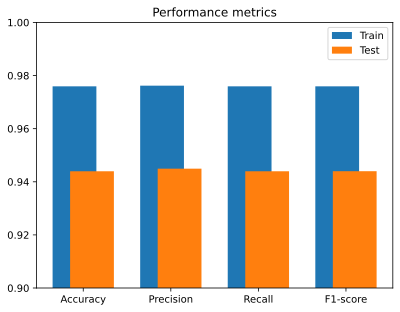

In [66]:
plt.bar(np.arange(4)-.1, train_metrics, .5)
plt.bar(np.arange(4)+.1, test_metrics, .5)
plt.xticks([0,1,2,3], ['Accuracy', 'Precision', 'Recall', 'F1-score'])
plt.ylim([.9,1])
plt.legend(['Train', 'Test'])
plt.title('Performance metrics')
plt.show()

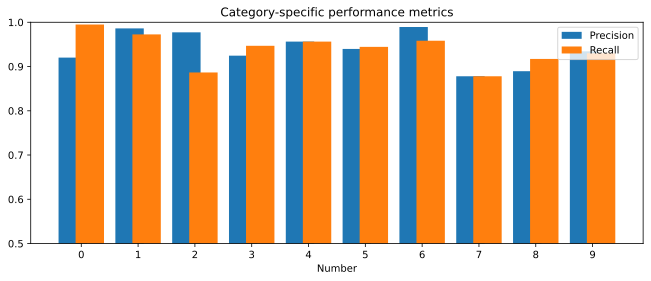

In [67]:
# Bar graphs of class-specific precision and recall for test data

precision = skm.precision_score(test_loader.dataset.tensors[1], test_predictions, average=None)
recall = skm.recall_score(test_loader.dataset.tensors[1], test_predictions, average=None)

fig = plt.figure(figsize=(11,4))
plt.bar(np.arange(10)-.15, precision, .5)
plt.bar(np.arange(10)+.15, recall, .5)
plt.xticks(range(10), range(10))
plt.ylim([.5,1])
plt.xlabel('Number')
plt.legend(['Precision', 'Recall'])
plt.title('Category-specific performance metrics')
plt.show()

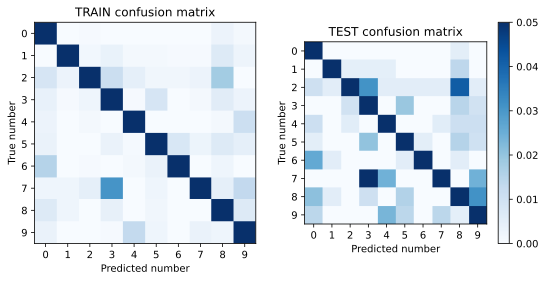

In [68]:
# Confusion matrices
train_conf = skm.confusion_matrix(train_loader.dataset.tensors[1], train_predictions, normalize='true')
test_conf = skm.confusion_matrix(test_loader.dataset.tensors[1], test_predictions, normalize='true')

fig, ax = plt.subplots(1,2,figsize=(9,4))

# confmat during TRAIN
ax[0].imshow(train_conf, 'Blues', vmax=.05)
ax[0].set_xticks(range(10))
ax[0].set_yticks(range(10))
ax[0].set_title('TRAIN confusion matrix')
ax[0].set_ylabel('True number')
ax[0].set_xlabel('Predicted number')

# confmat during TEST
a = ax[1].imshow(test_conf, 'Blues', vmax=.05)
ax[1].set_xticks(range(10))
ax[1].set_yticks(range(10))
ax[1].set_title('TEST confusion matrix')
ax[1].set_ylabel('True number')
ax[1].set_xlabel('Predicted number')

fig.colorbar(a)
plt.show()

# Computation time

## Import and process the data

In [69]:
# import dataset
data = np.loadtxt(open('sample_data/mnist_train_small.csv', 'rb'), delimiter=',')

# extract labels and remove from data
labels = data[:, 0]
data = data[:, 1:]

# normalize the data to a range of [0 1]
dataNorm = data / np.max(data)

In [70]:
# Step 1 : convert to tensor
data_tensor = torch.tensor(dataNorm).float()
labels_tensor = torch.tensor(labels).long()

# Step 2 : split the data
train_data, test_data, train_labels, test_labels = train_test_split(data_tensor, labels_tensor, test_size=.1)

# Step 3 : convert into PyTorch Datasets
trainset = TensorDataset(train_data, train_labels)
testset = TensorDataset(test_data, test_labels)

# Step 4 : translate into dataloader objects
batchsize=32
train_loader = DataLoader(trainset, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader = DataLoader(testset, batch_size=testset.tensors[0].shape[0])

## Create the DL model

In [71]:
# create a class for the model
def createTheMNISTNet():

    class mnistNet(nn.Module):
        def __init__(self):
            super().__init__()

            # input layer
            self.input = nn.Linear(784, 64)

            # hidden layer
            self.fc1 = nn.Linear(64,32)
            self.fc2 = nn.Linear(32,32)

            # output layer
            self.output = nn.Linear(32,10)

        # forward pas
        def forward(self, x):
            x = F.relu(self.input(x))
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            return self.output(x)

    # create the model instance
    net = mnistNet()

    # loss function
    lossfunc = nn.CrossEntropyLoss()

    # optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=.01)

    return net, lossfunc, optimizer

## Create a function that trains the model

In [72]:
def function2trainTheModel():

    # Start the timer!
    timerInFunction = time.process_time()

    # number of epochs
    numepochs = 10

    # create a new model
    net, lossfunc, optimizer = createTheMNISTNet()

    # initialize losses
    losses = torch.zeros(numepochs)
    trainAcc = []
    testAcc = []

    # loop over epochs
    for epochi in range(numepochs):

        # loop over training data batches
        batchAcc = []
        batchLoss = []
        for X, y in train_loader:

            # forward pass and loss
            yHat = net(X)
            loss = lossfunc(yHat, y)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # batch loss and accuracy
            batchLoss.append(loss.item())
            batchAcc.append( 100 * torch.mean((torch.argmax(yHat, axis=1)==y).float()).item() )

        # average loss & acc across the batches
        trainAcc.append( np.mean(batchAcc) )
        losses[epochi] = np.mean(batchLoss)

        # test accuracy
        X, y = next(iter(test_loader))
        with torch.no_grad():
            yHat = net(X)

        testAcc.append( 100 * torch.mean((torch.argmax(yHat, axis=1)==y).float()).item() )

        # Finally, report the epoch number, computation time, and accuracy
        comp_time = time.process_time() - timerInFunction
        print(f'Epoch {epochi+1} / {numepochs}, elapsed time: {comp_time:.2f} sec, test accuracy: {testAcc[-1]:.2f}%')

    # end epochs

    # function output
    return trainAcc, testAcc, losses, net

## Run the model and show the results!

In [73]:
# build and train the model
trainAcc, testAcc, losses, net = function2trainTheModel()

Epoch 1 / 10, elapsed time: 1.68 sec, test accuracy: 92.50%
Epoch 2 / 10, elapsed time: 3.69 sec, test accuracy: 91.80%
Epoch 3 / 10, elapsed time: 6.41 sec, test accuracy: 94.15%
Epoch 4 / 10, elapsed time: 9.31 sec, test accuracy: 95.00%
Epoch 5 / 10, elapsed time: 11.72 sec, test accuracy: 93.80%
Epoch 6 / 10, elapsed time: 14.58 sec, test accuracy: 94.40%
Epoch 7 / 10, elapsed time: 18.48 sec, test accuracy: 94.40%
Epoch 8 / 10, elapsed time: 21.13 sec, test accuracy: 95.10%
Epoch 9 / 10, elapsed time: 23.30 sec, test accuracy: 94.65%
Epoch 10 / 10, elapsed time: 25.50 sec, test accuracy: 94.80%


In [75]:
# now run a second timer over repeated iterations

# Start the timer! (note the different variable name)
timerOutsideFunction = time.process_time()

for i in range(2):
    function2trainTheModel()

TotalExperimentTime = time.process_time() - timerOutsideFunction
print(f'\n\n\nTotal elapsed experiment time: {TotalExperimentTime/60:.2f} minutes')

Epoch 1 / 10, elapsed time: 2.33 sec, test accuracy: 91.95%
Epoch 2 / 10, elapsed time: 4.10 sec, test accuracy: 90.75%
Epoch 3 / 10, elapsed time: 5.90 sec, test accuracy: 93.45%
Epoch 4 / 10, elapsed time: 7.83 sec, test accuracy: 93.60%
Epoch 5 / 10, elapsed time: 9.71 sec, test accuracy: 93.90%
Epoch 6 / 10, elapsed time: 11.63 sec, test accuracy: 94.50%
Epoch 7 / 10, elapsed time: 13.99 sec, test accuracy: 94.25%
Epoch 8 / 10, elapsed time: 16.35 sec, test accuracy: 94.15%
Epoch 9 / 10, elapsed time: 18.14 sec, test accuracy: 94.20%
Epoch 10 / 10, elapsed time: 20.12 sec, test accuracy: 94.95%
Epoch 1 / 10, elapsed time: 1.81 sec, test accuracy: 90.30%
Epoch 2 / 10, elapsed time: 3.59 sec, test accuracy: 92.50%
Epoch 3 / 10, elapsed time: 5.30 sec, test accuracy: 93.40%
Epoch 4 / 10, elapsed time: 7.60 sec, test accuracy: 92.20%
Epoch 5 / 10, elapsed time: 9.74 sec, test accuracy: 94.10%
Epoch 6 / 10, elapsed time: 11.90 sec, test accuracy: 95.10%
Epoch 7 / 10, elapsed time: 13.73

# Better performance in test than train?

In [ ]:
''' Several reasons why test accuracy might be higher than trian accuracy.

* Possible causes of test > train
- Random luck with small samples (nonsystematic).
- Test data are systematically easier to categorize.
- Test data are not normalized.
- Accuracy was horrible in the first batch of training and improved fast.
- Dropout regularization (left on during testing).
- Bug in the code ("test" data taken from training?).

* What to do with "inverse" results?
- Small differences (few %): probably not a big deal.
- Huge differences (e.g., 60% vs. 99%): probably a bug in the code.
- "Medium" differences: Check for too much regularization that unfairly hurts training;
  check that dropout and batchnorm are off during test; simplify the model architecture.
  '''